In [171]:
from pathlib import Path
import json
from tqdm import tqdm
import networkx as nx
import re

import matplotlib.pyplot as plt
import numpy as np

import re
import html
import codecs

In [247]:
ROOT = Path()

ENTITIES_PATH = ROOT / 'nsm_dataset' / 'webqsp' / 'entities.txt'
RELATIONS_PATH = ROOT / 'nsm_dataset' / 'webqsp' / 'relations.txt'

TEST_WEBQSP_SOURCE = ROOT / 'nsm_dataset' / 'webqsp' / 'test_simple.json'
TEST_WEBQSP = ROOT / 'webqsp_test_results.json'
TEST_WEBQSP_PROMPTS = ROOT / 'webqsp_test_results_PROMPTS.json'

ENTIRY2TEXT = ROOT / 'mentions' / 'entity_list_file_freebase_complete_all_mention'
ENTIRY2TEXT_DUMP = ROOT / 'mentions' / 'entity_list_file_freebase_complete_all_mention.json'

In [172]:
def decode_unicode_escapes(text):
    """Преобразует Unicode-экранированные последовательности в символы."""
    
    # Декодирование \uXXXX и \UXXXXXXXX (стандартный Python Unicode)
    decoded = codecs.decode(text, 'unicode_escape')
    
    # Декодирование $XXXX (альтернативный формат)
    decoded = re.sub(r'\$([0-9a-fA-F]{4})', lambda m: chr(int(m.group(1), 16)), decoded)
    
    # Декодирование HTML-сущностей (например, &amp; &#x003C;)
    decoded = html.unescape(decoded)
    
    return decoded

In [245]:
with open(TEST_WEBQSP, 'r') as f:
    data = json.load(f)

In [175]:
# if not ENTIRY2TEXT_DUMP.exists():
with open(ENTIRY2TEXT, 'r') as f:
    ent2txt = {}
    for line in tqdm(f, total=47187940):
        ent, txt, _ = line.strip().split('\t')
        ent2txt[ent] = decode_unicode_escapes(txt)

100%|██████████| 47187940/47187940 [00:57<00:00, 820459.55it/s]


In [176]:
with open(ENTIRY2TEXT_DUMP, 'w') as f:
    json.dump(ent2txt, f, indent=4)

In [246]:
def resolve_data(data):
    next_data = dict(id=data['id'], retrieved=[], answers=[])
    for ent, score in data['retrieved']:
        next_data['retrieved'].append((ent, ent2txt.get(ent, ent), score))
    for ent in data['answers']:
        next_data['answers'].append((ent, ent2txt.get(ent, ent)))
    next_data['question'] = data['question']
    return next_data


next_data = list(map(resolve_data, data))
with open(ROOT / 'webqsp_test_results_resolved.json', 'w') as f:
    json.dump(next_data, f)

In [237]:
def get_dict(path):
    word2idx, idx2word = dict(), dict()
    with open(path, encoding='utf-8') as f_in:
        for line in f_in:
            word = line.strip()
            idx = len(word2idx)
            word2idx[word] = idx
            idx2word[idx] = word
    return word2idx, idx2word


ent2idx, idx2ent = get_dict(ENTITIES_PATH)
rel2idx, idx2rel = get_dict(RELATIONS_PATH)

In [238]:
with open(TEST_WEBQSP_SOURCE, 'r') as f:
    for _ in range(np.random.randint(1000)):
        f.readline()
    test_data = json.loads(f.readline())
    
    
print(test_data['id'])
display(test_data['answers'])

my_data = None
for d in data:
    if d['id'] == test_data['id']:
        my_data = d.copy()

WebQTest-438


[{'kb_id': 'm.0l2tk', 'text': 'Brigham Young University'}]

In [239]:
G = nx.DiGraph()
for node_id_from, rel_id, node_id_to in test_data['subgraph']['tuples']:
    G.add_edge(
        idx2ent.get(node_id_from, node_id_from),
        idx2ent.get(node_id_to, node_id_to),
        relation=idx2rel.get(rel_id, rel_id),
    )

In [240]:
sp = dict(nx.all_pairs_shortest_path(G))

In [248]:
def resolve_path(G, sp, source_ent, target_ent):
    path = sp[source_ent][target_ent]
    get = lambda x: ent2txt.get(x, x)
    full_path = [get(path[0])]
    for i in range(1, len(path)):
        relation = G[path[i - 1]][path[i]]['relation']
        full_path.extend((relation, get(path[i])))
    return ' --> '.join(reversed(full_path)), path


enter_nodes = list(map(lambda x: idx2ent.get(x, None), test_data['entities']))
answer_nodes = list(map(lambda x: x['kb_id'], test_data['answers']))
retrieved_nodes = [e for e, _ in my_data['retrieved']]
prompts = []
nodes = []
for enter_node in enter_nodes:
    for ans in retrieved_nodes: # + answer_nodes
        try:
            prompt, path = resolve_path(G, sp, enter_node, ans)
            prompts.append(prompt)
            nodes.extend(path)
        except KeyError:
            pass

        try:
            prompt, path = resolve_path(G, sp, ans, enter_node)
            prompts.append(prompt)
            nodes.extend(path)
        except KeyError:
            pass

In [242]:
def extract_subgraph(G, nodes):
    nodes_set = set(nodes)
    
    _G = nx.DiGraph()
    
    for node in nodes:
        for neighbor in G.neighbors(node):
            if neighbor in nodes_set:
                relation = G[node][neighbor]['relation']
                _G.add_edge(node, neighbor, relation=relation)

    names = {node: ent2txt.get(node, node) for node in _G}
    nx.set_node_attributes(_G, names, 'name')
    return _G


_G = extract_subgraph(G, nodes)

mittens romney --> people.person.education --> m.02kvkg9 --> education.education.institution --> harvard law school
harvard law school --> location.location.containedby --> masachussets --> government.governmental_jurisdiction.government_positions --> list of massachusetts governors --> government.government_office_or_title.office_holders --> m.04stpgl --> government.government_position_held.office_holder --> mittens romney
mittens romney --> people.person.education --> m.02kvkfv --> education.education.institution --> hbs.edu
hbs.edu --> location.location.containedby --> masachussets --> government.governmental_jurisdiction.government_positions --> list of massachusetts governors --> government.government_office_or_title.office_holders --> m.04stpgl --> government.government_position_held.office_holder --> mittens romney
mittens romney --> people.person.education --> m.02kvkg9 --> education.education.degree --> dr. juris
mittens romney --> people.person.education --> m.02kvkfv --> edu

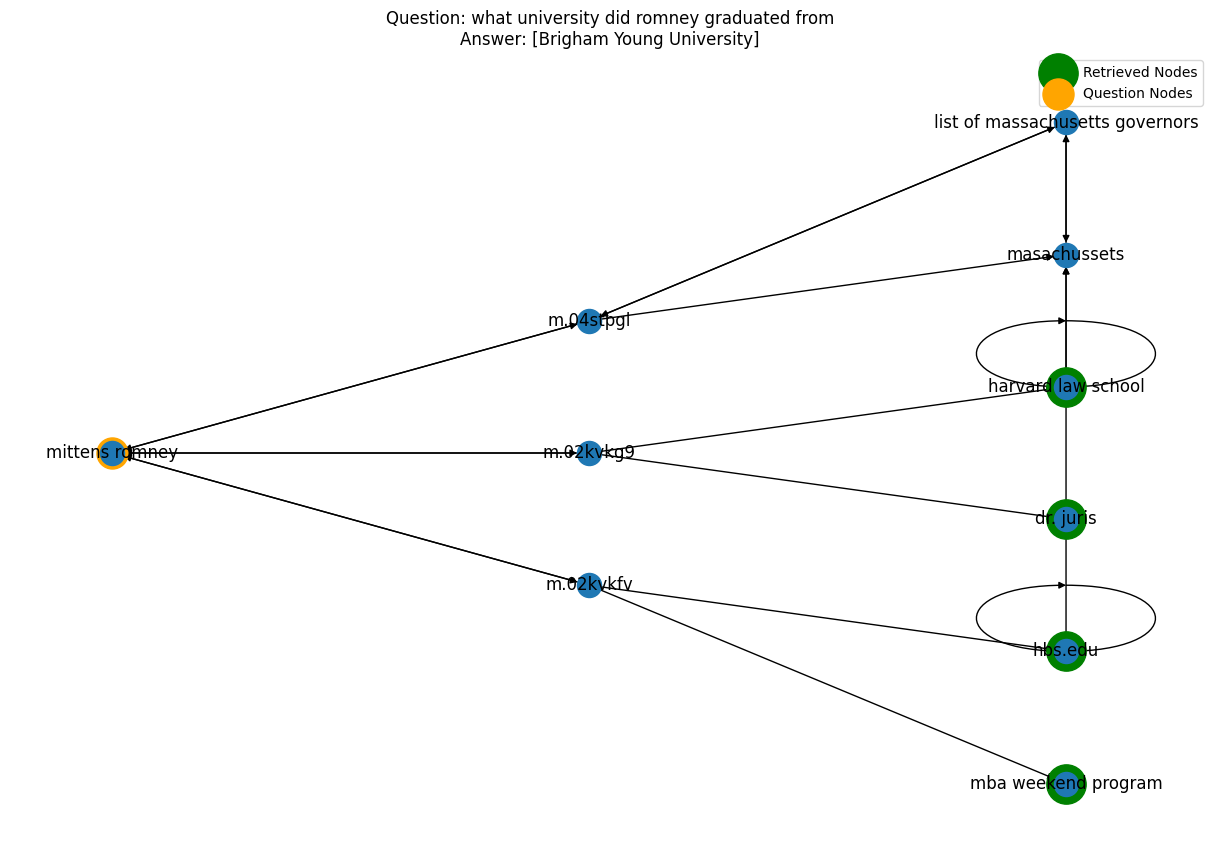

In [243]:
for prompt in prompts:
    print(prompt)

plt.figure(figsize=(12, 8))
pos = nx.bfs_layout(_G, enter_node)
# pos = nx.spring_layout(_G)

nx.draw(_G, pos=pos, with_labels=False)

names = nx.get_node_attributes(_G, 'name')
nx.draw_networkx_labels(_G, pos, labels=names)

# relats = nx.get_edge_attributes(_G, 'relation')
# nx.draw_networkx_edge_labels(_G, pos, edge_labels=relats)

ret_node = [e for e, _ in my_data['retrieved']]
x = np.array([pos[key] for key in ret_node if key in pos])
if len(x):
    plt.scatter(x[:,0], x[:,1], c='g', s=800, label='Retrieved Nodes')


inp_node = [idx2ent.get(d, d) for d in test_data['entities']]
x = np.array([pos[key] for key in inp_node if key in pos])
if len(x):
    plt.scatter(x[:,0], x[:,1], c='orange', s=500, label='Question Nodes')


ans_node = [d['kb_id'] for d in test_data['answers']]
x = np.array([pos[key] for key in ans_node if key in pos])
if len(x):
    plt.scatter(x[:,0], x[:,1], c='r', s=500, label='Answer Nodes')

s = ', '.join([f"[{d['text']}]" for d in test_data['answers']])
plt.title(f"Question: {test_data['question']}\nAnswer: {s}")

plt.axis("off")
plt.legend()
plt.show();

In [249]:
with open(TEST_WEBQSP_SOURCE, 'r') as f:
    result = {}
    i = 0;
    for line in tqdm(f, total=2):
        i += 1
        test_data = json.loads(f.readline())

        my_data = None
        for d in data:
            if d['id'] == test_data['id']:
                my_data = d.copy()

        G = nx.DiGraph()
        for node_id_from, rel_id, node_id_to in test_data['subgraph']['tuples']:
            G.add_edge(
                idx2ent.get(node_id_from, node_id_from),
                idx2ent.get(node_id_to, node_id_to),
                relation=idx2rel.get(rel_id, rel_id),
            )

        sp = dict(nx.all_pairs_shortest_path(G))

        enter_nodes = list(map(lambda x: idx2ent.get(x, None), test_data['entities']))
        answer_nodes = list(map(lambda x: x['kb_id'], test_data['answers']))
        retrieved_nodes = [e for e, _ in my_data['retrieved']]
        prompts = []
        nodes = []
        for enter_node in enter_nodes:
            for ans in retrieved_nodes:
                try:
                    prompt, path = prompt, path = resolve_path(G, sp, ans, enter_node)
                    prompts.append(prompt)
                    nodes.extend(path)
                except KeyError:
                    pass

                try:
                    prompt, path = prompt, path = resolve_path(G, sp, enter_node, ans)
                    prompts.append(prompt)
                    nodes.extend(path)
                except KeyError:
                    pass

        
        result[test_data['id']] = prompts
    
        if i == 100:
            break

99it [01:19,  1.24it/s]                      


In [250]:
with open(TEST_WEBQSP_PROMPTS, 'w', encoding='utf-8') as f:
    json.dump(result, f)

In [198]:
result

[{'id': 'WebQTest-1',
  'promts': ['united states speaker of the house of representatives --> government.government_office_or_title.office_holders --> m.0944j8_ --> government.government_position_held.office_holder --> young hickory',
   'united states congressperson --> government.government_office_or_title.jurisdiction --> los estados unidos de américa --> government.governmental_jurisdiction.government_positions --> us presidential --> government.government_office_or_title.office_holders --> m.04469y8 --> government.government_position_held.office_holder --> young hickory',
   'governor of tennessee --> government.government_office_or_title.office_holders --> m.04j5sk8 --> government.government_position_held.office_holder --> young hickory',
   'us presidential --> government.government_office_or_title.office_holders --> m.04469y8 --> government.government_position_held.office_holder --> young hickory']},
 {'id': 'WebQTest-6', 'promts': []},
 {'id': 'WebQTest-8',
  'promts': ['frank